In [1]:
from optparse import OptionParser
import json
import os
import pickle
import random
import re
import pandas as pd
import pysam
import h5py
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("/home1/smaruj/akitaX1-analyses/figures/plot_styles/global_plotting_style.mplstyle")
import seaborn as sns

In [2]:
# import tensorrt as trt (if installed, it's not used by Akita anyways)
import tensorflow as tf
from basenji import seqnn, stream

2024-06-07 14:39:46.838429: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 14:39:46.838474: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 14:39:46.839919: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-07 14:39:46.849462: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 14:39:48.323379: W tensorflow/comp

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' ### run on CPU

In [4]:
print(tf.config.list_physical_devices('GPU'))

[]


In [5]:
from akita_utils.dna_utils import dna_1hot

from akita_utils.seq_gens import (
    symmertic_insertion_seqs_gen,
    reference_seqs_gen,
)
from akita_utils.utils import split_df_equally

from akita_utils.h5_utils import (
    initialize_stat_output_h5,
    initialize_maps_output_h5,
    initialize_maps_output_references,
    write_stat_metrics_to_h5,
    write_maps_to_h5,
)

In [6]:
from akita_utils.tsv_gen_utils import (
    add_orientation,
    add_background,
    add_const_flank_and_diff_spacer,
)

In [7]:
# arguments 

genome_fasta = "/project/fudenber_735/genomes/mm10/mm10.fa" 
# stats = "SCD,INS-16,INS-64"
stats = "SCD"
batch_size=8
head_index = 1
model_index = 1
shifts = "0"
rc = False
background_file = f"/project/fudenber_735/akitaX1_analyses_data/background_generation/background_generation/background_sequences_model_{model_index}.fa"

In [8]:
# CTCT_table = "/home1/smaruj/akitaX1-analyses/experiments/virtual_insertion_experiment/input_data/CTCFs_jaspar_filtered_mm10_single_insertion_30flanks.tsv"
CTCT_table = "./random_10sites.tsv"

In [9]:
shifts = [int(shift) for shift in shifts.split(",")]
stats = stats.split(",")

In [10]:
models_dir="/project/fudenber_735/tensorflow_models/akita/v2/models"

In [11]:
params_file = models_dir + f"/f{model_index}c0" + "/train" + "/params.json"

In [12]:
params_file

'/project/fudenber_735/tensorflow_models/akita/v2/models/f1c0/train/params.json'

In [13]:
model_file = models_dir + f"/f{model_index}c0" + "/train" + f"/model{head_index}_best.h5"

In [14]:
model_file

'/project/fudenber_735/tensorflow_models/akita/v2/models/f1c0/train/model1_best.h5'

In [15]:
# read model parameters
with open(params_file) as params_open:
    params = json.load(params_open)
params_train = params["train"]
params_model = params["model"]

if batch_size is None:
    batch_size = params_train["batch_size"]
else:
    batch_size = batch_size

In [16]:
# load model
seqnn_model = seqnn.SeqNN(params_model)
seqnn_model.restore(model_file, head_i=head_index)
seqnn_model.build_ensemble(rc, shifts)
seq_length = int(params_model["seq_length"])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, 1310720, 4)]         0         []                            
                                                                                                  
 stochastic_reverse_complem  ((None, 1310720, 4),         0         ['sequence[0][0]']            
 ent (StochasticReverseComp   ())                                                                 
 lement)                                                                                          
                                                                                                  
 stochastic_shift (Stochast  (None, 1310720, 4)           0         ['stochastic_reverse_complemen
 icShift)                                                           t[0][0]']               

In [17]:
# open genome FASTA
genome_open = pysam.Fastafile(genome_fasta)

In [18]:
seq_coords_df = pd.read_csv(CTCT_table, sep="\t")[1:2].reset_index(drop=True)

In [19]:
seq_coords_df = seq_coords_df[["chrom", "end", "start", "strand"]]

In [20]:
seq_coords_df["seq_index"] = [0]

In [21]:
flank_length = 30
orient_list = [">>", "<<", "><", "<>"]
background_indices_list = [x for x in range(10)]
# inter-motif distance: 60, 100kb, 200kb, 400kb, 700kb
spacing_list=[0, 49970, 99970, 199970, 349970]

In [22]:
# adding orientation
seq_coords_df = add_orientation(
    seq_coords_df,
    orientation_strings=orient_list,
    all_permutations=False,
)

# adding background index
seq_coords_df = add_background(
    seq_coords_df, 
    background_indices_list
    )

In [23]:
seq_coords_df = add_const_flank_and_diff_spacer(
        seq_coords_df, 
        flank_length, 
        spacing_list
        )

In [ ]:
# seq_coords_df

In [24]:
background_seqs = []
    
with open(background_file, "r") as f:
    for line in f.readlines():
        if ">" in line:
            continue
        background_seqs.append(dna_1hot(line.strip()))

# num_insert_backgrounds = seq_coords_df["background_index"].max()
num_insert_backgrounds = 1

if len(background_seqs) < num_insert_backgrounds:
    raise ValueError(
        "must provide a background file with at least as many"
        + "backgrounds as those specified in the insert seq_coords tsv."
        + "\nThe provided background file has {len(background_seqs)} sequences."
    )

In [ ]:
# initialize output
# stats_out = initialize_stat_output_h5(out_dir, model_file, stats, seq_coords_df)

In [25]:
#################################################################
# predictions for references
backgrounds_predictions = seqnn_model.predict(np.array(background_seqs), batch_size=batch_size)

2/2 [==============================] - 15s 3s/step


In [26]:
preds_stream = stream.PredStreamGen(
        seqnn_model,
        symmertic_insertion_seqs_gen(seq_coords_df, background_seqs, genome_open),
        batch_size,
    )

In [27]:
num_experiments = len(seq_coords_df)

In [28]:
from akita_utils.stats_utils import plot_map

In [29]:
from akita_utils.utils import ut_dense

In [30]:
from akita_utils.stats_utils import calculate_SCD

In [31]:
summary_matrix = np.zeros((3, 4, 5, 6, 10, 130305))
# seq_index, orient_index, spacer_index, target_index, bg_index

In [32]:
for exp_index in range(num_experiments):
    
    print(f"experiment {exp_index}")

    seq_index = seq_coords_df.iloc[exp_index].seq_index
    orient = seq_coords_df.iloc[exp_index].orientation
    bg_index = seq_coords_df.iloc[exp_index].background_index
    spacer_index = spacing_list.index(seq_coords_df.iloc[exp_index].spacer_bp)

    if orient == ">>":
        orient_index = 0
    if orient == "<<":
        orient_index = 1    
    if orient == "><":
        orient_index = 2
    elif orient == "<>":
        orient_index = 3
    
    prediction_matrix = preds_stream[exp_index]
    reference_prediction_matrix = backgrounds_predictions[bg_index, :, :]

    difference_matrix = prediction_matrix - reference_prediction_matrix

    for target_index in range(6):
        summary_matrix[seq_index, orient_index, spacer_index, target_index, bg_index, :] += difference_matrix[:,target_index]
    
    # ref_maps_t0 = ut_dense(reference_prediction_matrix)
    # alt_maps_t0 = ut_dense(prediction_matrix)

    # print("ref")
    # plot_map(ref_maps_t0[:,:,0])
    # print("alt")
    # çlot_map(alt_maps_t0[:,:,0])
    # print("alt-ref")
    # plot_map(alt_maps_t0[:,:,0] - ref_maps_t0[:,:,0])

    # print("SCD, ref")
    # print(calculate_SCD(ref_maps_t0))
    # print("SCD, alt")
    # print(calculate_SCD(alt_maps_t0))
    # print("SCD, alt with ref")
    # print(calculate_SCD(alt_maps_t0, ref_maps_t0))    
    
    # write_stat_metrics_to_h5(prediction_matrix,
    #                             reference_prediction_matrix,
    #                             stats_out,
    #                             exp_index,
    #                             head_index,
    #                             model_index,
    #                              diagonal_offset=2,
    #                             stat_metrics=stats)   

experiment 0
4/4 [==============================] - 48s 12s/step
experiment 1
experiment 2
experiment 3
experiment 4
experiment 5
experiment 6
experiment 7
experiment 8
experiment 9
experiment 10
experiment 11
experiment 12
experiment 13
experiment 14
experiment 15
experiment 16
experiment 17
experiment 18
experiment 19
experiment 20
experiment 21
experiment 22
experiment 23
experiment 24
experiment 25
experiment 26
experiment 27
experiment 28
experiment 29
experiment 30
experiment 31
experiment 32
4/4 [==============================] - 41s 10s/step
experiment 33
experiment 34
experiment 35
experiment 36
experiment 37
experiment 38
experiment 39
experiment 40
experiment 41
experiment 42
experiment 43
experiment 44
experiment 45
experiment 46
experiment 47
experiment 48
experiment 49
experiment 50
experiment 51
experiment 52
experiment 53
experiment 54
experiment 55
experiment 56
experiment 57
experiment 58
experiment 59
experiment 60
experiment 61
experiment 62
experiment 63
experiment

In [33]:
ave_summary_matrix = summary_matrix.mean(axis=(3,4))
# seq_index, orient_index, spacer_index

In [34]:
ave_summary_matrix.shape

(3, 4, 5, 130305)

In [35]:
distance_set = [spacer*2 + 60 for spacer in spacing_list]

In [36]:
orientation_set = ['>>', '<<', '><', '<>']

In [37]:
from akita_utils.utils import ut_dense

In [38]:
seq_index = 0

In [39]:
distance_set

[60, 100000, 200000, 400000, 700000]

In [40]:
my_coordinates = seq_coords_df[seq_coords_df["seq_index"] == seq_index].iloc[0].chrom + "_" + str(seq_coords_df[seq_coords_df["seq_index"] == seq_index].iloc[0].start) + "-" + str(seq_coords_df[seq_coords_df["seq_index"] == seq_index].iloc[0].end)

In [41]:
my_coordinates

'chr2_93199043-93199062'

plotting: distance=60
plotting: distance=60
plotting: distance=60
plotting: distance=60
plotting: distance=100000
plotting: distance=100000
plotting: distance=100000
plotting: distance=100000
plotting: distance=200000
plotting: distance=200000
plotting: distance=200000
plotting: distance=200000
plotting: distance=400000
plotting: distance=400000
plotting: distance=400000
plotting: distance=400000
plotting: distance=700000
plotting: distance=700000
plotting: distance=700000
plotting: distance=700000


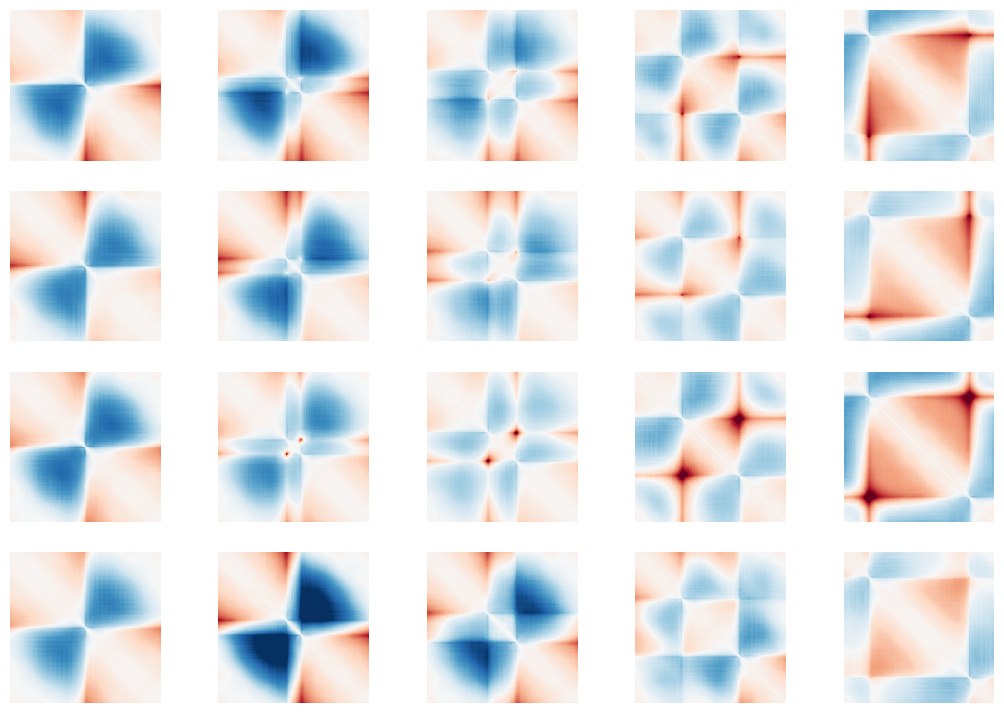

In [44]:
rows = [orientation for orientation in orientation_set]
cols = ["60bp", "100kb", "200kb", "400kb", "700kb"]

fig, axs = plt.subplots(len(orientation_set), len(distance_set), figsize=(13,9))

for spacer_idx in range(len(distance_set)):
    for orient_idx in range(len(orientation_set)):
        print(f"plotting: distance={distance_set[spacer_idx]}")
        
        plot_matrix = ut_dense(np.expand_dims(ave_summary_matrix[seq_index, orient_idx, spacer_idx, :], 1), diagonal_offset=2)
        plot_matrix = np.squeeze(plot_matrix, axis=2)
        # print(plot_matrix.shape)
        vmin = -0.6
        vmax = 0.6
        
        sns.heatmap(
            plot_matrix,
            ax=axs[orient_idx, spacer_idx],
            center=0,
            vmin=vmin,
            vmax=vmax,
            cbar=False,
            cmap="RdBu_r",
            square=True,
            xticklabels=False,
            yticklabels=False,
        )
        
# for ax, col in zip(axs[0], cols):
#     ax.set_title(col, size=15)

# for ax, row in zip(axs[:,0], rows):
#     ax.set_ylabel(row, rotation=0, fontsize=15, labelpad=15)

# a = np.array([[-0.6,0.6]])
# img = plt.imshow(a, cmap="RdBu_r")

# cb_ax = fig.add_axes([0.902, 0.110, 0.008, 0.165])
# cbar = fig.colorbar(img,orientation='vertical',cax=cb_ax)
# for t in cbar.ax.get_yticklabels():
#      t.set_fontsize(10)

# plt.savefig(f"./plots/{my_coordinates}_spacing_maps_200dpi.svg", format="svg", bbox_inches="tight", dpi=200)
plt.savefig(f"./plots/{my_coordinates}_spacing_maps.png", format="png", bbox_inches="tight", dpi=300)

plt.show()

In [45]:
print("done!")

done!


In [46]:
genome_open.close()